In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

# Sample non-negative matrix
V = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 1, 1, 0],
              [0, 0, 1, 1, 0, 1]
              ])
print("Orignal Matrix V: \n", V)

# We set n_components to 2, meaning we want to find a factorization with a rank of 2.
# We create an NMF object. 
# The init='random' parameter tells the algorithm to initialize W and H with random non-negative values. 
# Random_state=0 is used for reproducibility.

n_components = 2
model = NMF(n_components=n_components, init='random', random_state=42)
W = model.fit_transform(V)
H = model.components_

print("\nMatrix W (Document-Component matrix):\n", W)
print("\nMatrix H (Component-Term matrix):\n", H)

V_constructed = np.dot(W, H)
print('Reconstructed V Matrix: \n', V_constructed)

Orignal Matrix V: 
 [[1 0 0 1 0 0]
 [0 1 0 1 1 0]
 [0 0 1 1 0 1]]

Matrix W (Document-Component matrix):
 [[0.00000000e+00 1.01271248e+00]
 [1.39363280e+00 2.19581252e-04]
 [1.39410467e+00 0.00000000e+00]]

Matrix H (Component-Term matrix):
 [[0.00000000e+00 3.58653097e-01 3.58774543e-01 7.17349885e-01
  3.58653097e-01 3.58774543e-01]
 [9.87447056e-01 1.07087784e-04 0.00000000e+00 9.87447115e-01
  1.07087784e-04 0.00000000e+00]]
Reconstructed V Matrix: 
 [[9.99999953e-01 1.08449135e-04 0.00000000e+00 1.00000001e+00
  1.08449135e-04 0.00000000e+00]
 [2.16824861e-04 4.99830743e-01 4.99999971e-01 9.99939154e-01
  4.99830743e-01 4.99999971e-01]
 [0.00000000e+00 4.99999957e-01 5.00169266e-01 1.00006082e+00
  4.99999957e-01 5.00169266e-01]]


In [2]:
from IPython.display import HTML, display
import numpy.linalg as LA

In [ ]:
def simple_doc_processor(doc_list, words_to_remove):
    '''
    
    '''
    processed_docs = [] #empty list
    for doc in doc_list:
        words = doc.split(" ") # get words
        words = [word.lower() for word in words] # lowercase
        words = [word for word in words if word not in words_to_remove] #membership test
        processed_docs.append(words) # append as a list of words

    vocab = [j for i in processed_docs for j in i]
    unique_vocab = list(set(vocab))

    doc_vocabindex_list = []
    for doc in processed_docs:
        numeric_doc = [0] * len(unique_vocab)
        for word in doc:
            numeric_doc[unique_vocab.index(word)] = 1
        doc_vocabindex_list.append(numeric_doc)
    doc_word_matrix = np.array(doc_vocabindex_list)

    return (doc_word_matrix, unique_vocab)   


In [5]:
documents = [
             "I use statistics in Data Science",
             "I use linear algebra in Data Science",
             "I program in python",
             "Python is a great language to program with",
             'I use python for Data Science',
             "I program linear algebra in python"
]
words_to_remove = ['i', 'use', 'in', 'is', 'a', 'for', 'to', 'with']
doc_word_matrix, unique_vocab = simple_doc_processor(documents, words_to_remove)
doc_word_matrix

array([[1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [11]:
## THE NMF CLASS

class NMF():
    def __init__(self, A, no_topics=2,  **kwargs):
        self.A = A
        self.no_topics = no_topics
        self._no_documnets , self._no_words = self.A.shape
        self._epsilon = 2**-8

    def calc_reconstruction_error(self):
        """
        """
        if hasattr(self, 'H') and hasattr(self, 'W'):
            error = LA.norm(self.A - np.dot(self.W, self.H))
        else:
            error = None
        
        return error
    
    def randomize_wh(self):
        """
        """
        self.W = np.random.random((self._no_documnets, self.no_topics))
        self.H = np.random.random((self.no_topics, self._no_words))
    
    def update_h(self):
        # H = H .* (W'A) ./(W'WH + epsilon)
        AtW = np.dot(self.W.T, self.A)
        HWtW = np.dot(self.W.T.dot(self.W), self.H) + self._epsilon
        self.H *= AtW
        self.H /= HWtW

    def update_w(self):
        # W = W .* (AH') ./ (WHH' + epsilon) 
        AH = self.A.dot(self.H.T)
        WHtH = self.W.dot(self.H.dot(self.H.T)) + self._epsilon
        self.W *= AH
        self.W /= WHtH
    
    def perform_factorization(self, max_iter=100, tolerance=0.01):

        self.randomize_wh()
        self.reconstruction_error = np.zeros(max_iter)
        self.reconstruction_error[0] = self.calc_reconstruction_error()
        previous_error = self.reconstruction_error[0]

        num_of_iter = 0

        for i in range(1, max_iter):
            num_of_iter = i
            self.update_w()
            self.update_h()
            self.reconstruction_error[i] = self.calc_reconstruction_error()

            if (previous_error - self.reconstruction_error[i]) /self.reconstruction_error[0] < tolerance:
                break
            previous_error = self.reconstruction_error[i]

        return (self.W, self.H, self.reconstruction_error, num_of_iter)


max_iter = 100
nmf = NMF(doc_word_matrix, no_topics=2)
W, H, reconstruction_error, number_of_iterations = nmf.perform_factorization(max_iter)


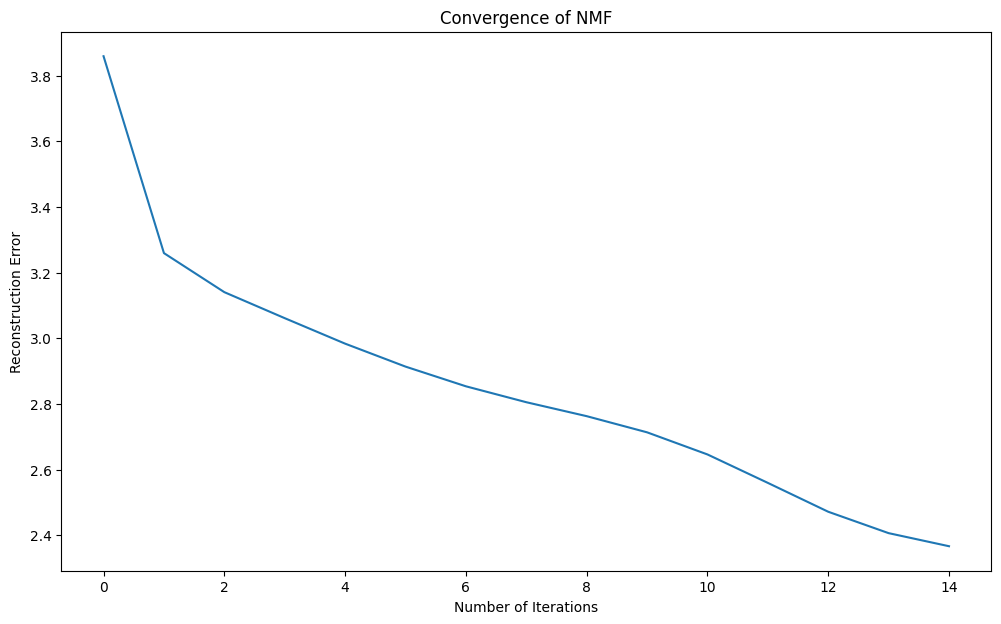

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
plt.plot(range(number_of_iterations), reconstruction_error[0:number_of_iterations])  

plt.xlabel("Number of Iterations")
plt.ylabel("Reconstruction Error")
plt.title("Convergence of NMF")

plt.show()